In [1]:
import os
import sys
import math
import random
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , BatchNormalization , Dropout , Activation
from tensorflow.keras.layers import LSTM , GRU
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
pd.options.display.max_colwidth = -1

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

RANDOM_STATE = 313
seed_everything(seed=RANDOM_STATE)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving testset.csv to testset.csv
Saving trainset.csv to trainset.csv


In [4]:
train = pd.read_csv('trainset.csv')
test = pd.read_csv('testset.csv')

Exploratory Data Analysis

In [ ]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [ ]:
train.dtypes

Date         object 
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       int64  
dtype: object

In [ ]:
train.describe(include='all')

,Date,Open,High,Low,Close,Adj Close,Volume
count,1259,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
unique,1259,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-03-18,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,652.704082,657.475653,647.433700,652.657015,652.657015,2.414928e+06
std,NaN,175.630574,176.627416,174.732814,175.820993,175.820993,1.672160e+06
min,NaN,350.053253,350.391052,345.512787,349.164032,349.164032,7.900000e+03
25%,NaN,528.287079,532.615204,524.232483,528.429413,528.429413,1.336900e+06
50%,NaN,600.002563,603.236511,594.453674,598.005554,598.005554,1.842300e+06
75%,NaN,774.015015,779.120025,768.662506,772.720002,772.720002,3.090850e+06


In [ ]:
date = pd.to_datetime(train["Date"])
min(date), max(date)

(Timestamp('2013-01-02 00:00:00'), Timestamp('2017-12-29 00:00:00'))

In [ ]:
train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
test.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

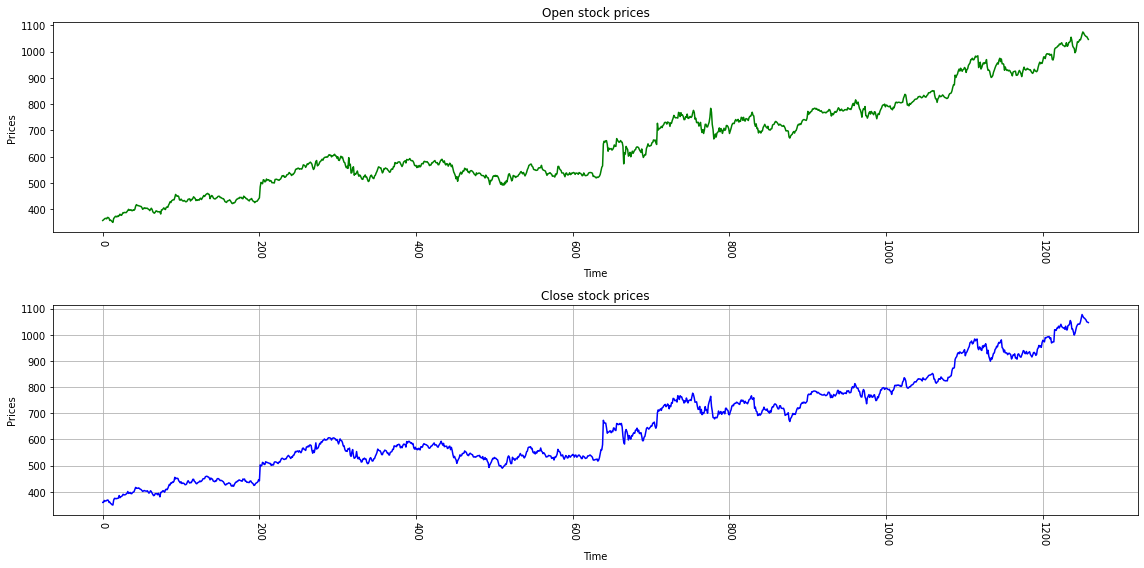

correlation: 0.9992


In [5]:
def plotter(data):
    open_values = data.Open.values.astype('float32').reshape(-1, 1)
    close_values = data.Close.values.astype('float32').reshape(-1, 1)
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Prices')
    axes[0].set_title('Open stock prices')
    axes[0].plot(open_values , 'g')
    axes[0].xaxis.set_tick_params(rotation=270)
    

    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Prices')
    axes[1].set_title('Close stock prices')
    axes[1].plot(close_values , 'b')
    axes[1].xaxis.set_tick_params(rotation=270)
    
    fig.tight_layout()
    plt.grid(True)
    plt.show()

plotter(train)

print(f"correlation: {np.around(train[['Open', 'Close']].corr().values[0, 1], 4)}")

Preprocessing

In [42]:
series_train = train[['Close']]
series_train_mean = series_train.mean().values.item()
series_train = series_train - series_train_mean
scaler = MinMaxScaler(feature_range=(0, 1))
series_train = scaler.fit_transform(series_train)

In [43]:
series_test = test[['Close']]
series_test_mean = series_test.mean().values.item()
series_test = series_test - series_test_mean
scaler = MinMaxScaler(feature_range=(0, 1))
series_test = scaler.fit_transform(series_test)


In [16]:
series_train

array([[0.01390725],
       [0.01419387],
       [0.02395214],
       ...,
       [0.96185311],
       [0.96016352],
       [0.95777334]])

In [17]:
series_test

array([[0.36415787],
       [0.46443314],
       [0.48692078],
       [0.57773056],
       [0.60474962],
       [0.60084914],
       [0.57991049],
       [0.59660413],
       [0.69263439],
       [0.6897661 ],
       [0.74839376],
       [0.73583099],
       [0.78011721],
       [0.88509687],
       [0.96632631],
       [0.93345583],
       [0.96862108],
       [1.        ],
       [0.99850843],
       [0.93030043],
       [0.96615405],
       [0.95330417],
       [0.63320352],
       [0.31138163],
       [0.45364835],
       [0.269963  ],
       [0.        ],
       [0.20800838],
       [0.28923782],
       [0.29015587],
       [0.39111951],
       [0.50481888],
       [0.53510818],
       [0.57904986],
       [0.62999071],
       [0.60297165],
       [0.71862126],
       [0.8159134 ],
       [0.66986034],
       [0.59207201],
       [0.39008732],
       [0.44401129],
       [0.51290765],
       [0.53659975],
       [0.62023881],
       [0.71408914],
       [0.90936248],
       [0.934

In [18]:
pd.DataFrame(series_train).describe()

,0
count,1259.000000
mean,0.416900
std,0.241520
min,0.000000
25%,0.246252
50%,0.341827
75%,0.581827
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe213b0438>]],
      dtype=object)

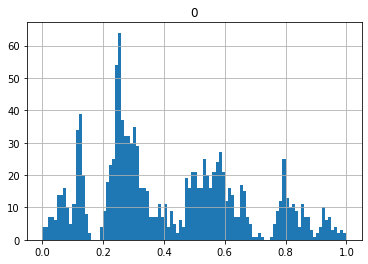

In [19]:
pd.DataFrame(series_train).hist(bins=100)

Modelling


In [20]:
def process_data(data, n_steps):
    X, y = list(), list()
    for i in range(len(data) - n_steps):
        sequence = data[i : (i + n_steps), 0]
        X.append(sequence)
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

In [44]:
n_steps = 2
X_train, y_train = process_data(series_train, n_steps)
X_test, y_test = process_data(series_test, n_steps)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1257, 2) (1257,) (123, 2) (123,)


In [45]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [46]:
filepath = './model.h5'
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_delta=0.0001, patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [47]:
model = Sequential()
model.add(GRU(256 , input_shape=(n_steps, 1) , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(32 ,  activation = 'relu'))
model.add(Dense(1))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 2, 256)            198912    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [48]:
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr = 0.0001) , metrics = ['mean_squared_error'])

In [49]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=256, 
                    callbacks=[checkpoint, lr_reduce], 
                    validation_data=(X_test, y_test))

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.2182 - mean_squared_error: 0.2182
Epoch 00001: val_loss improved from inf to 0.29690, saving model to ./model.h5
5/5 [==============================] - 1s 207ms/step - loss: 0.2182 - mean_squared_error: 0.2182 - val_loss: 0.2969 - val_mean_squared_error: 0.2969
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1865 - mean_squared_error: 0.1865
Epoch 00002: val_loss improved from 0.29690 to 0.25931, saving model to ./model.h5
5/5 [==============================] - 0s 72ms/step - loss: 0.1865 - mean_squared_error: 0.1865 - val_loss: 0.2593 - val_mean_squared_error: 0.2593
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.1598 - mean_squared_error: 0.1598
Epoch 00003: val_loss improved from 0.25931 to 0.22250, saving model to ./model.h5
5/5 [==============================] - 0s 74ms/step - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.2225 - val_mean_squared_error: 0.2225
E

In [50]:
# Load best model
model = load_model(filepath)

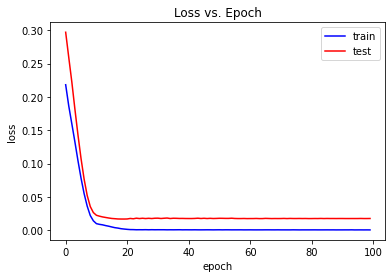

In [51]:
# Plot loss vs epoch
plt.plot(history.history['loss'], color='b', label='train')
plt.plot(history.history['val_loss'], color='r', label='test')
plt.title('Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [52]:
def model_score(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (train_score[0], math.sqrt(train_score[0])))
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (test_score[0], math.sqrt(test_score[0])))

model_score(model, X_train, y_train , X_test, y_test)

Train Score: 0.00102 MSE (0.03 RMSE)
Test Score: 0.01691 MSE (0.13 RMSE)


In [54]:
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred) + series_test_mean
pred

array([[1071.1475 ],
       [1082.5378 ],
       [1089.5759 ],
       [1100.5164 ],
       [1103.1676 ],
       [1101.6417 ],
       [1100.3147 ],
       [1107.2013 ],
       [1117.3499 ],
       [1120.2294 ],
       [1125.9196 ],
       [1126.9817 ],
       [1137.672  ],
       [1153.9926 ],
       [1161.3224 ],
       [1159.6014 ],
       [1165.4138 ],
       [1168.9226 ],
       [1164.8104 ],
       [1159.1017 ],
       [1162.4431 ],
       [1142.8076 ],
       [1090.9017 ],
       [1065.2817 ],
       [1070.363  ],
       [1039.0051 ],
       [1023.19745],
       [1046.9354 ],
       [1054.949  ],
       [1060.0361 ],
       [1075.9421 ],
       [1089.215  ],
       [1094.6761 ],
       [1101.9955 ],
       [1105.9607 ],
       [1109.2745 ],
       [1127.0693 ],
       [1129.6727 ],
       [1109.6277 ],
       [1090.728  ],
       [1072.7407 ],
       [1081.7756 ],
       [1090.1343 ],
       [1097.0015 ],
       [1110.8785 ],
       [1131.7301 ],
       [1154.947  ],
       [1149.

In [55]:
y_test = y_test[..., np.newaxis]
y_test = scaler.inverse_transform(y_test) + series_test_mean

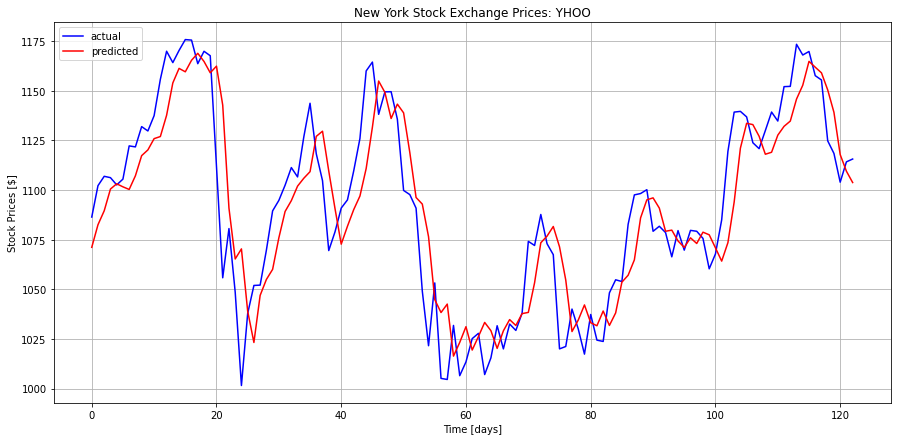

In [56]:
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(y_test, label='actual', color='b')
plt.plot(pred, label='predicted', color='r')
plt.xlabel('Time [days]')
plt.ylabel('Stock Prices [$]')
plt.title('New York Stock Exchange Prices: YHOO')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()